# Regresión lineal y técnicas de validación


La regresión lineal es un modelo que mapeo una o más variables continuas hacia una variable también continua definido como

$$
f_\theta(\vec x_i) = \theta_0 + \sum_{j=1}^M \theta_j x_{ij} 
$$

Asumiendo que tenemos $N$ ejemplos para entrenar, podemos plantear el sistema de ecuaciones matricialmente como

$$
Y = X \theta
$$

donde $Y= \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\y_N\end{pmatrix} \in \mathbb{R}^N$, $X = \begin{pmatrix} 1 & x_{11} & x_{12}& \ldots& x_{1M} \\ \vdots & \vdots & \vdots& \ddots& \vdots \\ 1 & x_{N1} & x_{N2}& \ldots& x_{NM} \\ \end{pmatrix} \in \mathbb{R}^{N\times M}$ y $\theta \in \mathbb{R}^M$

La suma de errores cuadrados en formato matricial es

$$
L(\theta) = \frac{1}{2} (Y - X\theta)^T (Y - X\theta)
$$

Luego si derivamos e igualamos a cero obtenemos

$$
\nabla_\theta L(\theta) = -X^T(Y-X\theta) = 0,
$$

y despejando

$$
\hat \theta = (X^T X)^{-1} X^T Y
$$

siempre $X^T X$ no sea singular

:::{note}

Esto se conoce como solución de mínimos cuadrados

:::

## Regresión lineal en Scikit-Learn

La solución de mínimos cuadrados está implementada en la librería scikit-learn como [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Sus principales argumentos son

- `fit_intercept=True`: Ajustar o no el parámetro $\theta_0$
- `n_jobs`: Número de nucleos de CPU

Sus principales métodos son

- `fit(X, y)`: Ajuste los parámetros según la solución de mínimos cuadrados. 
- `predict(X)`: Retorna la predicción para un conjunto de datos
- `score(X, y)`: Retorna el [coeficiente de determinación](https://es.wikipedia.org/wiki/Coeficiente_de_determinaci%C3%B3n)

:::{note}

- `X` es un ndarray de dos dimensiones
- `y` es un ndarray de una dimensión

:::

Los principales atributos son

- `intercept_`: Corresponde a $\theta_0$
- `coef_`: Es un arreglo con $\theta_j$ para $j>0$


Consideremos los siguientes datos 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1234)
x = np.random.randn(30)
y = -0.5*x**4 + 2*x**3 -3 + np.random.randn(len(x))

Para ajustar el modelo a este dataset utilizamos

In [2]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
print(f"Coeficiente de determinación: {model.score(x.reshape(-1, 1), y)}")

Coeficiente de determinación: 0.6603211449252782


Luego para realizar una predicción sobre nuevos datos:

In [3]:
x_test = np.linspace(x.min(), x.max(), 200)
y_test = model.predict(x_test.reshape(-1, 1))

A continuación se grafican los datos y la predicción del modelo (izquierda) junto a los residuos del modelo (derecha)

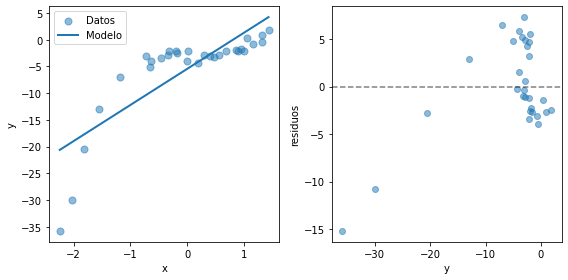

In [4]:
def plot_prediction(x, y, x_test, y_test, model):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
    ax[0].scatter(x, y, s=50, label='Datos', alpha=0.5)
    ax[0].plot(x_test, y_test, label='Modelo', lw=2, )
    ax[0].legend()
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[1].scatter(y, y - model.predict(x.reshape(-1, 1)), alpha=0.5)
    ax[1].axhline(0, c='k', ls='--', alpha=0.5)
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('residuos')
    
plot_prediction(x, y, x_test, y_test, model)   

:::{note}

El gráfico de residuos es un gráfico de dispersión de $y$ versus $y - f_\theta(x)$, es bastante usado para analizar los errores de un modelo de regresión. Idealmente los residuos deberían estar concentrados en torno a cero

:::

También podemos medir la calidad del modelo utilizando el error medio cuadrático, que es la suma de errores cuadrados dividido por la cantidad de datos:

In [5]:
from sklearn.metrics import mean_squared_error
print(f"MSE: {mean_squared_error(y, model.predict(x.reshape(-1, 1))):0.4f}")

MSE: 24.1281


## Regresión polinomial con Scikit-Learn

Podemos generalizar el regresor lineal aplicando transformaciones a los datos. Por ejemplo una regresión polinomial de grado $M$ sería

$$
f_\theta(x_i) = \sum_{j=1}^M w_j x_{i}^j + b, 
$$

y su solución sería

$$
\hat \theta = (\Phi^T \Phi)^{-1} \Phi^T Y,
$$

donde 

$$
\Phi = \begin{pmatrix} 1 & x_1 & x_1^2& \ldots& x_1^M \\ \vdots & \vdots & \vdots& \ddots& \vdots \\ 1 & x_N & x_N^2& \ldots& x_N^M \\ \end{pmatrix}
$$

> El grado del polinomio es un **hiperparámetro** del modelo

En scikit learn podemos utilizar [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) para realizar esta transformación

Por ejemplo un polinomio de grado dos:

In [6]:
from sklearn.preprocessing import PolynomialFeatures

featurizer = PolynomialFeatures(degree=2)

display(x[0], featurizer.fit_transform(x[0].reshape(-1, 1)))

0.47143516373249306

array([[1.        , 0.47143516, 0.22225111]])

Podemos crear un regresor polinomial definiendo un [`Pipeline`](`https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline`)

El siguiente pipeline combina `PolynomialFeatures` y `LinearRegression`

In [7]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=3), 
                      LinearRegression(fit_intercept=False))

model.fit(x.reshape(-1, 1), y)
print(f"MSE: {mean_squared_error(y, model.predict(x.reshape(-1, 1))):0.4f}")
y_test = model.predict(x_test.reshape(-1, 1))

MSE: 0.7179


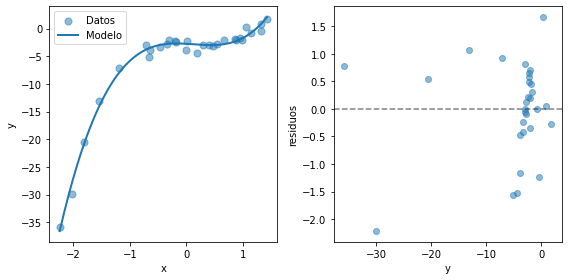

In [8]:
plot_prediction(x, y, x_test, y_test, model)

Ciertamente, el modelo sigue mejor la tendencia de los datos

> ¿Qué ocurre su usamos un polinomio de grado mayor?

Intentemos nuevamente con un polinomio de grado 15

In [9]:
model = make_pipeline(PolynomialFeatures(degree=15), 
                      LinearRegression())

model.fit(x.reshape(-1, 1), y)
print(f"MSE: {mean_squared_error(y, model.predict(x.reshape(-1, 1))):0.4f}")
y_test = model.predict(x_test.reshape(-1, 1))

MSE: 0.2526


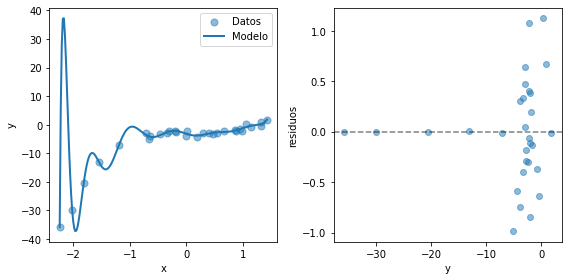

In [10]:
plot_prediction(x, y, x_test, y_test, model)

:::{warning}

Lo que estamos viendo es un ejemplo de sobreajuste

:::

## Complejidad y Sobreajuste

En el ejemplo anterior aumentar el grado del polinomio vuelve más flexible al modelo, es decir que aumenta su capacidad para ajustar los datos

:::{note}

La cantidad de parámetros o complejidad del modelo está relacionado con su flexibilidad

:::

Sin embargo, si la flexibilidad es excesiva podríamos aproximar ciertos datos con error cero. Esta situación, en que el modelo "memoriza los datos", se conoce como **sobreajuste**

:::{warning}

Un modelo sobreajustado tiende a predecir muy mal datos "que no ha visto": Pierde capacidad de **generalización**

:::

La siguiente figura esquematiza la relación la complejidad o capacidad de ajustar del modelo


<img src="img/overfitting.png" width="400">

Figura: https://www.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html

:::{note}

En general, mientras más simple sea el modelo, menos propenso es a sobreajustarse

:::

:::{hint}

Podemos evitar el escenario sobreajustado en modelos complejos utilizando un conjunto de datos de validación

:::

## Estrategias de Validación

Para combatir el sobreajuste podemos usar **estrategias de validación**, estas se basan en separar el conjunto de datos en dos o más subconjuntos, revisemos dos de ellas

**Holdout**

Consiste en separar los datos en conjuntos de entrenamiento, validación y prueba:

- El primero se ocupa para entrenar o ajustar el modelo
- El segundo se utiliza para detectar sobreajuste y calibrar los hiperparámetros del modelo
- El tercero se ocupa para realizar una evaluación final libre de sesgos

Típicamente, la base de datos se particiona en proporción 80%, 10%, 10% si el dataset es grande o 60%, 20%, 20% si el dataset es pequeño

**K-fold**

La validación cruzada o K-fold consisten en separar el conjunto en $K$ particiones y utilizarlas alternadamente para entrenar y validar como muestra el siguiente esquema

<img src="img/cv.png" width="400">

El caso extremo se conoce como Leave-one-out (LOO), en que se entrena con todos los datos menos uno $N$ veces.


> Para ambos tipos de validación los conjuntos se seleccionan aleatoriamente. También puede hacerse de forma estratificada, es decir manteniendo la proporción de clases


Podemos separar un conjunto en dos con scikit-learn utilizando:

30 24 6


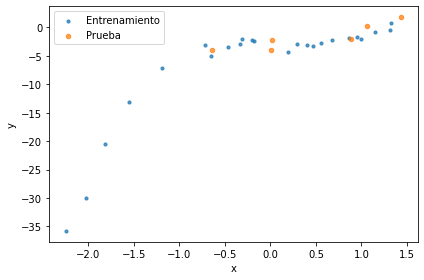

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(len(y), len(y_train), len(y_test))

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.scatter(X_train, y_train, s=10, label='Entrenamiento', alpha=0.75)
ax.scatter(X_test, y_test, s=20, label='Prueba', alpha=0.75)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y');

En el ejemplo del regresor polinomial podemos utilizar **validación cruzada** para seleccionar el grado de polinomio óptimo

Para esto utilizarmos la función [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Los argumentos de esta función son

- Un modelo de scikit learn
- Datos 
- Etiquetas
- `cv`: La cantidad de particiones (K)
- `scoring`: Una métrica que se utiliza para evaluar el modelo en las particiones

En este ejemplo utilizaremos 5 particiones y el error cuadrático medio como métrica

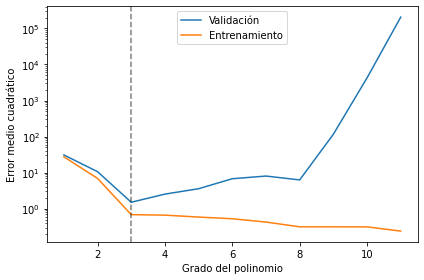

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

val_scores = []
train_scores = []
for degree in range(1, 12):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    scorer = make_scorer(mean_squared_error)
    val_scores.append(cross_val_score(model, X=X_train.reshape(-1, 1), y=y_train, cv=5, scoring=scorer))
    model.fit(X_train.reshape(-1, 1), y_train)
    train_scores.append(mean_squared_error(y_train, model.predict(X_train.reshape(-1, 1))))
    
score_mean = [score.mean() for score in val_scores]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(range(1, 12), score_mean, label='Validación')
ax.plot(range(1, 12), train_scores, label='Entrenamiento')
ax.axvline(3, ls='--', c='k', alpha=0.5)
ax.set_yscale('log')
plt.legend()
ax.set_xlabel('Grado del polinomio')
ax.set_ylabel('Error medio cuadrático');

En resumen

- Bajo error de entrenamiento y de validación: **Ideal**
- Bajo error de entrenamiento y alto error de validación: **Modelo sobreajustado**
- Alto error de entrenamiento y de validación: Considera un modelo de mayor complejidad y asegurate que tu código no tenga bugs
